# **RETINAL OCT MULTICLASS IMAGE CLASSIFICATION WITH RESNET**

In [ ]:
# Import module provided by Google Colab for file upload needs
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annisarizki","key":"9c43aecbe8433cfbbabad07116a73480"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018
!unzip kermany2018.zip

Streaming output truncated to the last 5000 lines.
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8050636-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055145-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8055590-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-1.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-2.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-3.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-4.jpeg  
  inflating: oct2017/__MACOSX/OCT2017 /train/NORMAL/._NORMAL-8056259-5.jpeg  
  inflating: 

In [ ]:
# Import the required modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.utils.data as D
import torch.nn.functional as F

import torchvision
import torchvision.models as models
from torchvision import datasets, models
from torchvision.utils import make_grid
import torchvision.transforms as tt
import tensorflow as tf

import copy
import time
import os, shutil
from itertools import product
from tqdm.notebook import tqdm as tq
from tqdm import trange

import glob
import cv2 as cv
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

from PIL import Image
import numpy as np
import pandas as pd
import random
from random import sample
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import seaborn as sns
plt.style.use(['seaborn-dark'])
mpl.rcParams.update({"axes.grid" : True, 
                     "grid.color": "grey",
                     'grid.linestyle':":",})

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.warn("UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change.")
warnings.filterwarnings("ignore")

In [ ]:
!rm -rf oct2017

# **DEVELOPING DATASETS INTO DATA TRAINING, VALIDATION, AND TESTING**

In [ ]:
# Call the path
oct_path= 'OCT2017/train/'

filename = []
labels = []
fullpath = []
for path, subdirs, files in os.walk(oct_path):
    for name in files:
        fullpath.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        filename.append(name)

In [ ]:
# Create dataframe from the result above
df_oct = pd.DataFrame({"path":fullpath,'filename':filename,"labels":labels})
# View the amount of image data on each label
df_oct.groupby(['labels']).size()

labels
CNV       37205
DME       11348
DRUSEN     8616
NORMAL    26315
dtype: int64

In [ ]:
# Variables used in this data separation where x = data path and y = data labels
X= df_oct['path']
y= df_oct['labels']

# Split the initial dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# The test data is divided into 2 so that it becomes test data and validation data
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=100)

In [ ]:
# Integrate into each dataframe
df_tr = pd.DataFrame({'path':X_train,
                      'labels':y_train,
                      'set':'train'})

df_te = pd.DataFrame({'path':X_test,
                      'labels':y_test,
                      'set':'test'})

df_val = pd.DataFrame({'path':X_val,
                      'labels':y_val,
                      'set':'val'})

In [ ]:
# Print the results above to see the length of the training, validation and testing data sizes
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 66787
test size 8348
val size 8349


In [ ]:
# See the proportions in each set whether it's ok or there is still something you want to change
df_all = df_tr.append([df_te, df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','labels']).size(),'\n')

print('===================================================== \n')

# Check the sample data
df_all.sample(5)


set    labels
test   CNV        3735
       DME        1175
       DRUSEN      830
       NORMAL     2608
train  CNV       29779
       DME        9056
       DRUSEN     6910
       NORMAL    21042
val    CNV        3691
       DME        1117
       DRUSEN      876
       NORMAL     2665
dtype: int64 




path  labels    set
50842        OCT2017/train/DME/DME-9915316-73.jpeg     DME  train
3463          OCT2017/train/DME/DME-3264056-9.jpeg     DME  train
77225        OCT2017/train/CNV/CNV-137351-121.jpeg     CNV    val
18548         OCT2017/train/CNV/CNV-268839-35.jpeg     CNV  train
50818  OCT2017/train/NORMAL/NORMAL-2444883-22.jpeg  NORMAL  train

In [ ]:
# Calls the original dataset containing the entire image data that matches the label
data_source_path = "OCT2017"
# Create a Dataset variable, which will later accommodate the data that has been divided into training, testing, and validation data
dataset_path = "Dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    # Detect filepath
    filepath = row['path']
    if os.path.exists(filepath) == False:
            filepath = os.path.join(data_source_path,row['labels'],row['image'].split('.')[0])            
    
    # Create a folder destination directory
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))
    
    # Specify the destination of the file
    destination_file_name = filepath.split('/')[-1]
    filedest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
    
    # Copy files from source to destination
    if os.path.exists(filedest) == False:
        shutil.copy2(filepath,filedest)

0it [00:00, ?it/s]

# **VISUALIZATION SAMPLE IMAGE OF EACH CLASS**

In [ ]:
oct_image = {}

path = "Dataset"

# Make dictionary storing images for each category under train data.
path_train = os.path.join(path, "train")
for i in os.listdir(path_train):
    oct_image[i] = os.listdir(os.path.join(path_train, i))

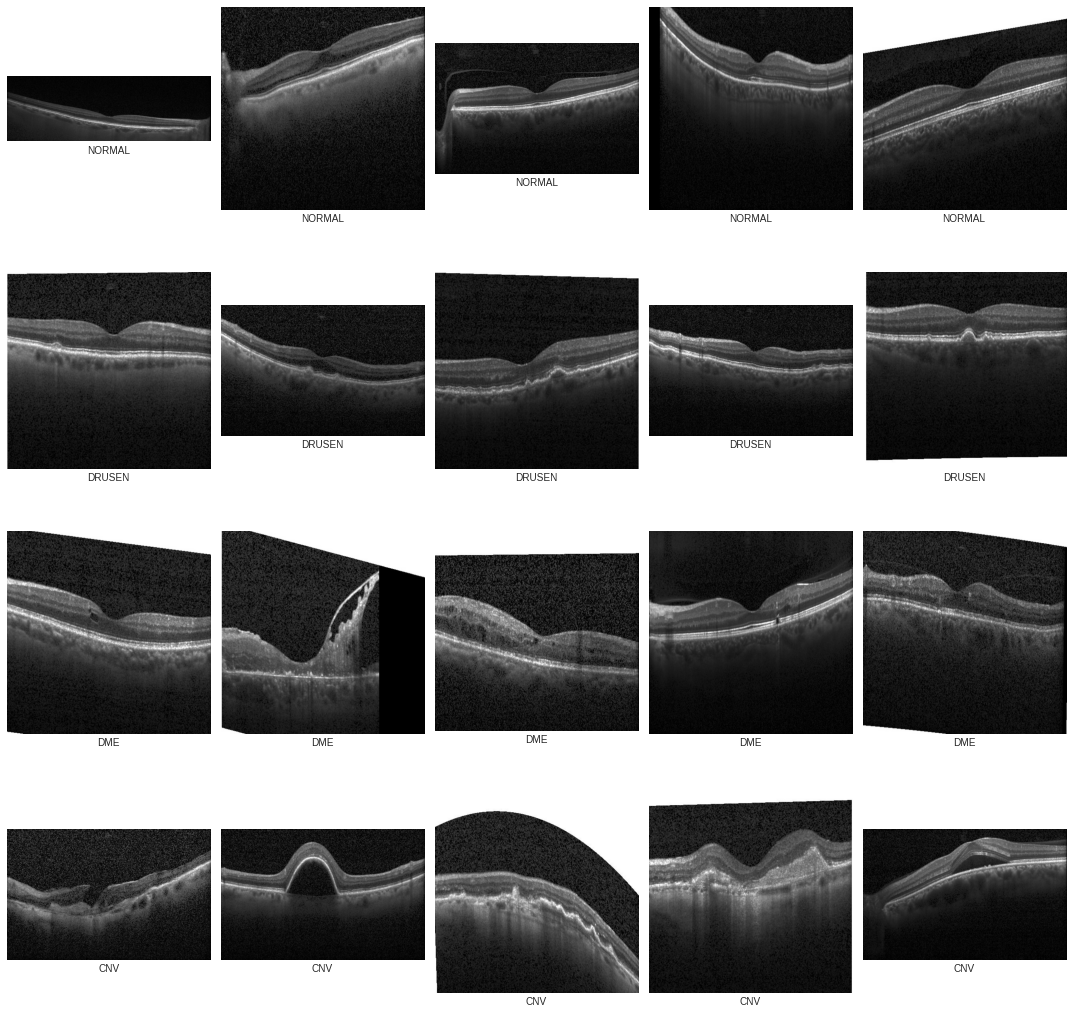

In [ ]:
# Randomly display 5 images under each of the 4 categories from the training data.
# You will see different images each time.

path_train= 'Dataset/train/'

fig, axs = plt.subplots(len(oct_image.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(oct_image[item], 5)
    
    for j, image in enumerate(images):
        img = Image.open(os.path.join(path_train, item, image)).convert('RGB')
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()
fig.savefig('oct-train.png')

# **SET GPU DEVICE**

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    # Print(f"Moved to {device}")
    return data.to(device, non_blocking=True)

# Pick GPU if available, else CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# **SET NORMALIZATION STATS FOR EACH RGB CHANNEL OF DATASET**

In [ ]:
def get_stats_channels(path="./", batch_size=50):
    """
    Create two tuples with mean and std for each RGB channel of the dataset
    """
    data_oct = datasets.ImageFolder(path, tt.Compose([tt.CenterCrop(490),
                                                      tt.ToTensor()]))
    loader = DataLoader(data_oct, batch_size, num_workers=4, pin_memory=True)

    nimages = 0
    mean = 0.
    std = 0.
    for batch, _ in tq(loader):
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)


    mean /= nimages
    std /= nimages

    return mean, std
normalization_stats = (0.1899, 0.1899, 0.1899), (0.1912, 0.1912, 0.1912)

# **DO TRANSFORM DATA**

In [ ]:
# Do transfrom data with center crop, convert toTensor, and normalize
data_transforms = {
    'Train': tt.Compose([tt.CenterCrop(490),
                         tt.ToTensor(), tt.Normalize(*normalization_stats)]),
    'Valid': tt.Compose([tt.CenterCrop(490),
                         tt.ToTensor(), tt.Normalize(*normalization_stats)]),
    'Test': tt.Compose([tt.CenterCrop(490),
                        tt.ToTensor(), tt.Normalize(*normalization_stats)])
}

# Set train, test, and valid data by combining original data and results transform data
data_dir = 'Dataset'

train_data = datasets.ImageFolder(data_dir+"/"+"train/", 
                                  transform=data_transforms["Train"])
valid_data = datasets.ImageFolder(data_dir+"/"+"val/", 
                                  transform=data_transforms["Valid"])
test_data = datasets.ImageFolder(data_dir+"/"+"test/",
                                 transform=data_transforms["Test"])

In [ ]:
# Set label and number of files create in dictionary form
train_dict = {'CNV': 29832, 'DME': 9026, 'DRUSEN': 6887, 'NORMAL': 21042}
valid_dict = {'CNV': 3679, 'DME': 1156, 'DRUSEN': 849, 'NORMAL': 2665}
test_dict =  {'CNV': 3694, 'DME': 1166, 'DRUSEN': 880, 'NORMAL': 2608}
train_labels = pd.Series(train_dict)
valid_labels = pd.Series(valid_dict)
test_labels = pd.Series(test_dict)

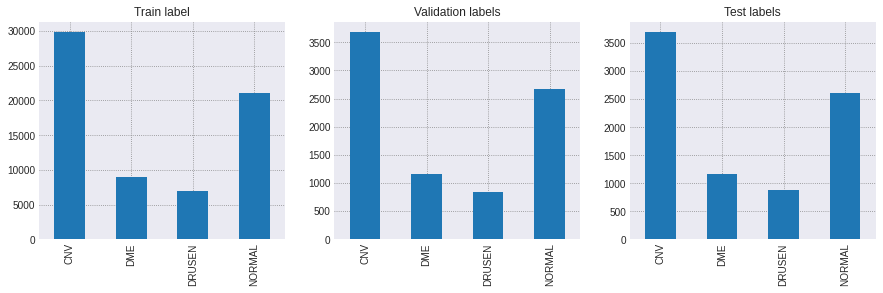

In [ ]:
# Show the number of files in each dataset
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15,4), sharex=True)
train_labels.plot(ax=ax1, kind="bar")
ax1.set(title="Train label")

valid_labels.plot(ax=ax2, kind="bar")
ax2.set(title="Validation labels")

test_labels.plot(ax=ax3, kind="bar")
ax3.set(title="Test labels")

plt.show()

# **HANDLING IMBALANCE CLASS PROBLEMS**

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
        
        taken from https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # If indices is not provided, 
        # All elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # Define custom callback
        self.callback_get_label = callback_get_label

        # If num_samples is not provided, 
        # Draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # Distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # Weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if isinstance(dataset, torchvision.datasets.MNIST):
            return dataset.train_labels[idx].item()
        elif isinstance(dataset, torchvision.datasets.ImageFolder):
            return dataset.imgs[idx][1]
        elif isinstance(dataset, torch.utils.data.Subset):
            return dataset.dataset.imgs[idx][1]
        elif self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

# **CREATE DATA LOADER**

In [ ]:
# Set size of batch size
BATCH_SIZE = 30
# Apply function ImbalancedDatasetSampler for training data
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, 
                              sampler=ImbalancedDatasetSampler(train_data, num_samples=4000), 
                              pin_memory=True, num_workers=2)
valid_dataloader =DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True, num_workers=2)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
valid_dataloader = DeviceDataLoader(valid_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

# **BUILD RESNET34 MODEL**

In [ ]:
class TransferResnet(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, classes=4):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        
        # Self.network.avgpool = AdaptiveConcatPool2d()
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(nn.Linear(num_ftrs, 128), 
                                        nn.ReLU(),  
                                        nn.Dropout(0.50), 
                                        
                                        nn.Linear(128,classes))
    
    def forward(self, xb):
        out = self.network(xb)
        return out

    def feed_to_network(self, batch):
        images, labels = batch 
        out = self(images)  
        loss = F.cross_entropy(out, labels)
        # Don't pass the softmax to the cross entropy
        out = F.softmax(out, dim=1)
        return loss, out

In [ ]:
model = TransferResnet()
model = to_device(model, device)
model

TransferResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
if torch.cuda.is_available():
    print('current memory allocated: {}'.format(torch.cuda.memory_allocated() / 1024 ** 2))
    print('max memory allocated: {}'.format(torch.cuda.max_memory_allocated() / 1024 ** 2))
    print('cached memory: {}'.format(torch.cuda.memory_reserved() / 1024 ** 2))

current memory allocated: 164.82421875
max memory allocated: 164.82421875
cached memory: 194.0


In [ ]:
def try_batch(dl):
    for batch in dl:
        loss, out = model.feed_to_network(batch)
        out = out[0]
        print(f"prediction of first element: {torch.argmax(out)}")
        print(f"Actual label: {batch[1][0]}")
        break

try_batch(train_dataloader)

prediction of first element: 1
Actual label: 2


# **DO TRAINING AND VALIDATION**

In [ ]:
# Create function to get score prediction
def get_scores(labels, prediction, loss=None):
    "Return classification scores"
    accuracy = accuracy_score(labels, prediction) 
    f1 = f1_score(labels, prediction, 
                  average='weighted', zero_division=0)
    precision = precision_score(labels, prediction, 
                                average='weighted', zero_division=0)
    recall = recall_score(labels, prediction, 
                          average='weighted', zero_division=0)
    if loss:
        return [accuracy, f1, precision, recall, loss]
    else: 
        return [accuracy, f1, precision, recall]

# Create function to get result prediction
def get_predictions(model, loader):
    """This function takes a model and a data loader, 
    returns the list of losses, the predictions and the labels"""

    model.eval() # Switch model to prediction mode

    with torch.no_grad():
        
        losses = []
        predictions = []
        labels = []
        
        for batch in loader:
            loss, out = model.feed_to_network(batch)
            
            predictions += torch.argmax(out, dim=1).tolist()
            labels += batch[1].tolist()
            losses.append(loss.item())
            
        return labels, predictions, sum(losses)/len(losses)

In [ ]:
def new_fit(model, train_loader, val_loader, 
            optimizer=torch.optim.Adam, lr=1e-2, epochs =10):
    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']

    train_metrics_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 
                                             'recall', 'loss'])
    valid_metrics_df = pd.DataFrame(columns=['accuracy', 'f1', 'precision', 
                                             'recall', 'loss'])

    optimizer = optimizer([{"params": model.network.fc.parameters(), "lr": lr},
                           {"params": model.network.layer4.parameters(), "lr": lr/2.5},
                           {"params": model.network.layer3.parameters(), "lr": lr/5},
                           {"params": model.network.layer2.parameters(), "lr": lr/10},
                           {"params": model.network.layer1.parameters(), "lr": lr/100},], lr, weight_decay=1e-5)

    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

    lr_list = []
    for epoch in range(epochs):
        
        model.train()
        
        lr_list.append(get_lr(optimizer))

        
        train_label = []
        train_prediction = []
        train_losses = []

        for batch in tq(train_loader):
            optimizer.zero_grad()
            loss, out = model.feed_to_network(batch)
            loss.backward()
            optimizer.step()
            
            
            # Extract labels, predictions and loss of the training set
            train_prediction += torch.argmax(out, dim=1).tolist()
            train_label += batch[1].tolist()
            train_losses.append(loss.item())
        
        # Evaluation phase
        val_labels, val_predictions, val_loss = get_predictions(model, val_loader)
        
        train_metrics_df.loc[epoch] = get_scores(train_label,train_prediction,
                                                 loss=sum(train_losses)/len(train_losses))
        valid_metrics_df.loc[epoch] = get_scores(val_labels, val_predictions, 
                                                 loss=val_loss)
        
        
        print_epoch_trainLoss = train_metrics_df.iloc[epoch]["loss"]
        print_epoch_validLoss = valid_metrics_df.iloc[epoch]["loss"]
        print_epoch_validAccu = valid_metrics_df.iloc[epoch]["accuracy"]
        print_epoch_trainAccu = train_metrics_df.iloc[epoch]["accuracy"]
        
        sched.step(print_epoch_trainLoss)

        
        print(f"\t\tEpoch {epoch+1}\t\n"
              f"Train loss:{train_losses[-1]:.4f}\tValid loss:{print_epoch_validLoss:.4f}\n"
              f"Train accuracy :{print_epoch_trainAccu*100:.2f}\tValid accuracy :{print_epoch_validAccu*100:.2f}")
        
        
    return train_metrics_df, valid_metrics_df, lr_list

In [ ]:
# Run training
train_output = new_fit(model, train_dataloader, valid_dataloader, lr=0.004, epochs=15)
# Display output of train metrics and valid metrics
train_metrics_df = train_output[0]
valid_metrics_df = train_output[1] 
lr_list = train_output[2]
# Save result of metrics to csv file
train_metrics_df.to_csv('oct-train-eval.csv', index=None)
valid_metrics_df.to_csv('oct-valid-eval.csv', index=None)

  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 1	
Train loss:1.3468	Valid loss:0.8612
Train accuracy :72.92	Valid accuracy :77.34


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 2	
Train loss:0.0639	Valid loss:0.5680
Train accuracy :86.95	Valid accuracy :81.04


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 3	
Train loss:0.2419	Valid loss:0.2913
Train accuracy :88.70	Valid accuracy :92.18


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 4	
Train loss:0.1310	Valid loss:0.2525
Train accuracy :90.33	Valid accuracy :92.60


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 5	
Train loss:1.1519	Valid loss:0.2188
Train accuracy :90.33	Valid accuracy :93.40


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 6	
Train loss:0.2790	Valid loss:0.2290
Train accuracy :90.83	Valid accuracy :93.20


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 7	
Train loss:0.0862	Valid loss:0.2829
Train accuracy :91.15	Valid accuracy :92.29


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 8	
Train loss:0.3416	Valid loss:0.1847
Train accuracy :91.92	Valid accuracy :94.61


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 9	
Train loss:0.9675	Valid loss:0.2960
Train accuracy :92.85	Valid accuracy :92.19


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 10	
Train loss:0.1107	Valid loss:0.2730
Train accuracy :90.90	Valid accuracy :92.29


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 11	
Train loss:0.1092	Valid loss:0.1950
Train accuracy :93.12	Valid accuracy :94.84


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 12	
Train loss:0.7623	Valid loss:0.2071
Train accuracy :93.00	Valid accuracy :94.62


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 13	
Train loss:0.1878	Valid loss:0.3015
Train accuracy :92.53	Valid accuracy :90.20


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 14	
Train loss:0.0751	Valid loss:0.2400
Train accuracy :93.83	Valid accuracy :93.27


  0%|          | 0/134 [00:00<?, ?it/s]

		Epoch 15	
Train loss:0.0993	Valid loss:0.1881
Train accuracy :93.00	Valid accuracy :93.64


# **VISUALIZATION ACCURACY, RECALL, PRECISION, F1, LOSS GRAPH OF TRAINING AND VALIDATION RESULT**

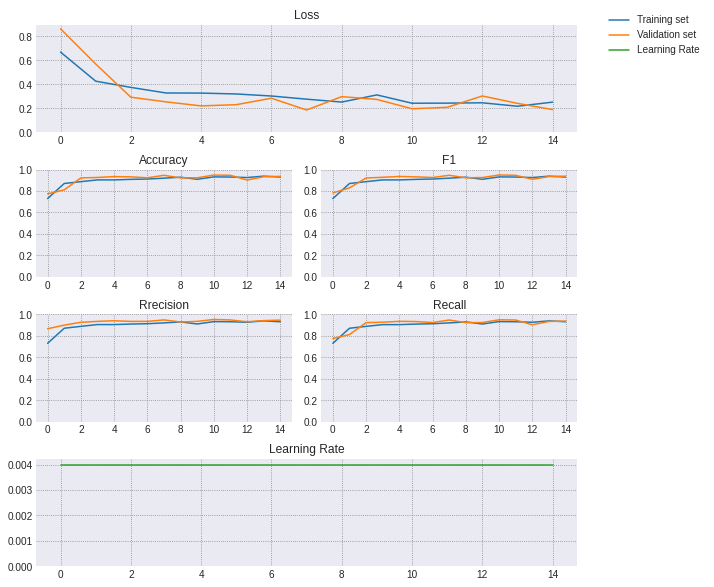

In [ ]:
# Make a graph plot of the results of the accuracy of training validation and loss training validation
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig = plt.figure(constrained_layout=True, figsize=(8,8))
gs = fig.add_gridspec(nrows=4, ncols=2)

fig_ax1 = fig.add_subplot(gs[0, :])
fig_ax1.plot(train_metrics_df["loss"], label="train")
fig_ax1.plot(valid_metrics_df["loss"])
fig_ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax1.set(title='Loss')
fig_ax1.set_ylim(bottom=0)

fig_ax2 = fig.add_subplot(gs[1, 0])
fig_ax2.plot(train_metrics_df["accuracy"], label="train")
fig_ax2.plot(valid_metrics_df["accuracy"], label="validation")
fig_ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax2.set(title="Accuracy", ylim=(0,1))

fig_ax3 = fig.add_subplot(gs[1, 1])
fig_ax3.plot(train_metrics_df["f1"], label="train")
fig_ax3.plot(valid_metrics_df["f1"], label="validation")
fig_ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax3.set(title="F1", ylim=(0,1))

fig_ax4 = fig.add_subplot(gs[2, 0])
fig_ax4.plot(train_metrics_df["precision"], label="train")
fig_ax4.plot(valid_metrics_df["precision"], label="validation")
fig_ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax4.set(title="Rrecision", ylim=(0,1))

fig_ax5 = fig.add_subplot(gs[2, 1])
fig_ax5.plot(train_metrics_df["recall"], label="train")
fig_ax5.plot(valid_metrics_df["recall"], label="validation")
fig_ax5.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax5.set(title="Recall", ylim=(0,1))

fig_ax6 = fig.add_subplot(gs[3, :])
fig_ax6.plot(lr_list, label="learning rate", color=colors[2])
fig_ax6.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_ax6.set(title='Learning Rate')
fig_ax6.set_ylim(bottom=0)


dummytrain = mlines.Line2D([], [], color=colors[0], label='Train set')
dummyvalid = mlines.Line2D([], [], color=colors[1], label='Validation set')
dummyrate = mlines.Line2D([], [], color=colors[2], label='Learning Rate')


fig.legend([dummytrain, dummyvalid,dummyrate], 
           ["Training set", "Validation set", "Learning Rate"],
           bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# **SAVE THE BEST MODEL RESULTS**

In [ ]:
checkpoint = {'model': TransferResnet(),
              'state_dict': TransferResnet().state_dict(),
              }
torch.save(checkpoint, 'oct-checkpoint.pth')

# **TESTING WITH DATA TESTING**

{'CNV': {'precision': 0.9872592592592593, 'recall': 0.9027363858033053, 'f1-score': 0.9431078403622983, 'support': 3691}, 'DME': {'precision': 0.9125541125541126, 'recall': 0.9435989256938228, 'f1-score': 0.9278169014084507, 'support': 1117}, 'DRUSEN': {'precision': 0.725130890052356, 'recall': 0.9486301369863014, 'f1-score': 0.8219584569732937, 'support': 876}, 'NORMAL': {'precision': 0.9730639730639731, 'recall': 0.9759849906191369, 'f1-score': 0.9745222929936306, 'support': 2665}, 'accuracy': 0.936399568810636, 'macro avg': {'precision': 0.8995020587324253, 'recall': 0.9427376097756416, 'f1-score': 0.9168513729344183, 'support': 8349}, 'weighted avg': {'precision': 0.9452302093125191, 'recall': 0.936399568810636, 'f1-score': 0.9383782532982531, 'support': 8349}}


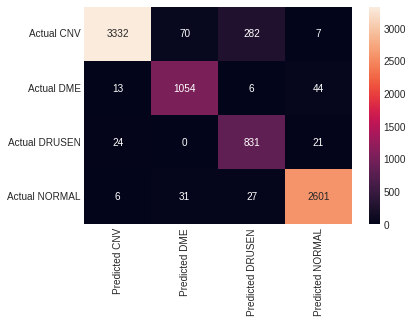

In [ ]:
labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
test_labels, test_predictions, _ = get_predictions(model, valid_dataloader)
classification_metrics = classification_report(test_labels, test_predictions, output_dict=True,
                            zero_division = 0, target_names=labels)
print(classification_metrics)

cm = pd.DataFrame(data=confusion_matrix(test_labels, test_predictions, labels=[0, 1, 2, 3]),index=["Actual CNV", "Actual DME", "Actual DRUSEN", "Actual NORMAL"],
columns=["Predicted CNV", "Predicted DME", "Predicted DRUSEN", "Predicted NORMAL"])
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
report = pd.DataFrame(classification_metrics)
report.to_csv('report-retinal-oct.csv', index=None)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('oct-checkpoint.pth')
print(model)

TransferResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

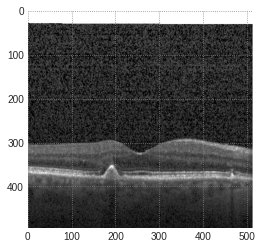

In [ ]:
image_path ='OCT2017/test/DRUSEN/DRUSEN-1112835-1.jpeg'
pil_image = Image.open(image_path).convert('RGB')
plt.imshow(pil_image)

In [ ]:
def process_image(pil_image):
    transforms = tt.Compose([
        tt.Resize((224, 224)),
        tt.CenterCrop(490)
        tt.ToTensor(),
        tt.Normalize([0.1899, 0.1899, 0.1899], [0.1912, 0.1912, 0.1912])
    ])
    pil_image = transforms(pil_image).float()
    
    np_image = np.array(pil_image)    
            
    return np_image

In [ ]:
def predict(pil_image, model):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Use GPU if it's available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(device)

    model.to(device)
    model.eval()
    
    np_image = process_image(pil_image)
    tensor_image = torch.from_numpy(np_image)
    
    inputs = Variable(tensor_image)
    
    if torch.cuda.is_available():
        inputs = Variable(tensor_image.float().cuda())           
        
    inputs = inputs.unsqueeze(dim = 0)
    logits = model.forward(inputs)
    probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
    labels = ['CNV', 'DME', 'DRUSEN', 'Normal']
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': probabilities}, index=labels)
    return probabilities, labels, result

probabilities, labels, result = predict(pil_image, model)
print(probabilities)
print(labels)
print(result)

[7.7448152e-03 3.2662434e-12 9.9225521e-01 1.5770033e-10]
['CNV', 'DME', 'DRUSEN', 'Normal']
                   p
CNV     7.744815e-03
DME     3.266243e-12
DRUSEN  9.922552e-01
Normal  1.577003e-10


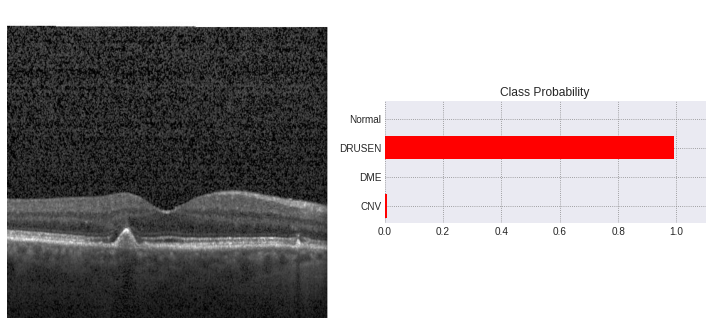

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(pil_image)
ax1.axis('off')
ax2.barh(np.arange(4), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(4))
ax2.set_yticklabels(labels)
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

# **COLORECTAL MNIST MULTICLASS IMAGE CLASSIFICATION WITH RESNET**

In [ ]:
# Import module provided by Google Colab for file upload needs
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annisarizki","key":"9c43aecbe8433cfbbabad07116a73480"}'}

In [ ]:
# Download kaggle dataset and unzip the file
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/colorectal-histology-mnist
!unzip colorectal-histology-mnist.zip

Streaming output truncated to the last 5000 lines.
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-02_025.tif_Row_1_Col_301.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/103F_CRC-Prim-HE-10_013.tif_Row_151_Col_1.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/10437_CRC-Prim-HE-02_028.tif_Row_151_Col_451.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/104D5_CRC-Prim-HE-09_024.tif_Row_451_Col_151.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/1055E_CRC-Prim-HE-01_027.tif_Row_151_Col_301.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000/01_TUMOR/105C1_CRC-Prim-HE-07_022.tif_Row_151_Col_1.tif  
  inflating: kather_texture_2016_image_tiles_5000/Kather_texture_2016_image

# **VISUALIZATION SAMPLE IMAGE OF EACH CLASS**

In [ ]:
# Form DataFrame with image paths and corresponding labels to use in PyTorch Dataset class.
SMALL_IMAGE_DATA_DIR = os.path.join('kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000')

filename = []
labels = []
fullpath = []
for path, subdirs, files in os.walk(SMALL_IMAGE_DATA_DIR):
    for name in files:
        fullpath.append(os.path.join(path, name)) 
        labels.append(path.split('/')[-1])        
        filename.append(name)

In [ ]:
# Create dataframe from the result above
df_colorectal = pd.DataFrame({"path":fullpath,'filename':filename,"labels":labels})
# View the amount of image data on each label
df_colorectal.groupby(['labels']).size()

labels
01_TUMOR      625
02_STROMA     625
03_COMPLEX    625
04_LYMPHO     625
05_DEBRIS     625
06_MUCOSA     625
07_ADIPOSE    625
08_EMPTY      625
dtype: int64

In [ ]:
colorectal_image = {}

path = 'kather_texture_2016_image_tiles_5000'
# Make dictionary storing images for each category under train data.
path_colorectal = os.path.join(path, "Kather_texture_2016_image_tiles_5000")
for i in os.listdir(path_colorectal):
    colorectal_image[i] = os.listdir(os.path.join(path_colorectal, i))

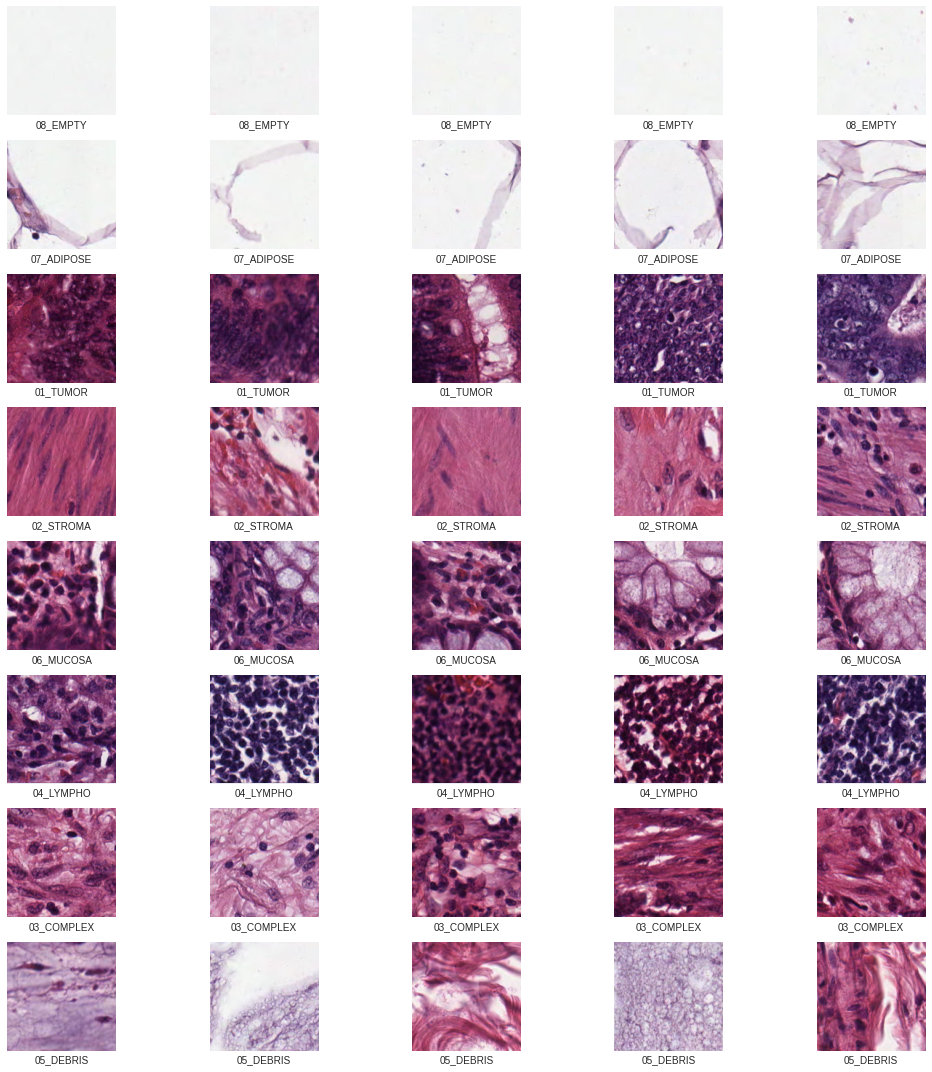

In [ ]:
# Randomly display 5 images under each of the 8 categories from the training data.
# You will see different images each time.

path_colorectal = 'kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

fig, axs = plt.subplots(len(colorectal_image.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_colorectal)):
    images = sample(colorectal_image[item], 5)
    
    for j, image in enumerate(images):
        img = Image.open(os.path.join(path_colorectal, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()
fig.savefig('colorectal-train.png')

In [ ]:
# Let’s map string label into integer number (label encoding procedure)
label_num = {}
for idx, item in enumerate(np.unique(df_colorectal.labels)):
    label_num[item] = idx

df_colorectal['label_num'] = df_colorectal['labels'].apply(lambda x: label_num[x])

# **PYTORCH DATASET, DATALOADERS AND TRANSFORMERS PREPARATION**

In [ ]:
class HistologyColorectal(D.Dataset):
    def __init__(self, df_colorectal, transforms, mode='train'):

        self.records = df_colorectal.to_records(index=False)
        self.transforms = transforms
        self.mode = mode
        self.len = df_colorectal.shape[0]
    
    @staticmethod
    def _load_image_pil(path):
        return Image.open(path)
        
    def __getitem__(self, index):
        path = self.records[index].path

        img = self._load_image_pil(path)
        
        if self.transforms:
            img = self.transforms(img)

        if self.mode in ['train', 'val', 'test']:
            return img, torch.from_numpy(np.array(self.records[index].label_num))
        else:
            return img

    def __len__(self):
        return self.len

In [ ]:
# Here is the basic transforms for training, validation and testing dataset, but you can add other augmentations to increase variance of the data.
train_transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **DEVELOPING DATASETS INTO DATA TRAINING, VALIDATION, AND TESTING**

In [ ]:
# Split the data into training, validation and testing datasets. 
# Train set usually used to adjust the weights, validation set - for hyperparameters optimization, and test set is for model performance testing.
train_df, test_df = train_test_split(df_colorectal,
                                    test_size=0.2,  
                                    random_state=2000,
                                    stratify=df_colorectal['labels'])

valid_df, test_df = train_test_split(test_df,
                                    test_size=0.8,  
                                    random_state=2000,
                                    stratify=test_df['labels'])

In [ ]:
# Print the results above to see the amount of the training, validation and testing data shape
print("Train DF shape:", train_df.shape)
print("Valid DF shape:", valid_df.shape)
print("Test DF shape:", test_df.shape)

Train DF shape: (4000, 4)
Valid DF shape: (200, 4)
Test DF shape: (800, 4)


# **CREATE DATASET OBJECTS AND CORRESPONDING DATA LOADERS**

In [ ]:
ds_train = HistologyColorectal(train_df, train_transforms)
ds_val = HistologyColorectal(valid_df, val_transforms, mode='val')
ds_test = HistologyColorectal(test_df, val_transforms, mode='test')

In [ ]:
train_loader = D.DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=4)
val_loader = D.DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=4)
test_loader = D.DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=4)

# **BUILD RESNET50 MODEL, DO TRAINING AND VALIDATION**

In [ ]:
# Create directory to save the best model
checkpoints_dir = 'best_model/'

history_train_loss, history_val_loss = [], []
history_train_acc, history_val_acc = [], []

def train_model(model, loss, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10
    best_acc_score = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                scheduler.step()
                model.train() # Set model to training mode
            else:
                dataloader = val_loader
                model.eval() # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tq(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
            if phase == 'train':
                history_train_loss.append(epoch_loss)
                history_train_acc.append(epoch_acc)
            else:
                history_val_loss.append(epoch_loss)
                history_val_acc.append(epoch_acc)
            
            if phase == 'val':
                def save_checkpoint(name):
                    checkpoint = {
                        'state_dict': best_model_wts
                    }

                    model_file_name = name + '.pth.tar'

                    model_file = checkpoints_dir + model_file_name

                    if not os.path.exists(checkpoints_dir):
                        os.mkdir(checkpoints_dir)

                    # Saving best weights of model
                    torch.save(checkpoint, model_file)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Saving model for best loss")
                    save_checkpoint('best_model')
                
                if epoch_acc > best_acc_score:
                    best_acc_score = epoch_acc
                    
                print('Best_loss: {:.4f}'.format(best_loss))
                print('Best_acc_score: {:.4f}'.format(best_acc_score))

    return model

In [ ]:
# Create classes based on folder name in directory SMALL_IMAGE_DATA_DIR
classes = os.listdir(SMALL_IMAGE_DATA_DIR)
#Set GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Build ResNet model with 50 layers, replace last linear layer to satisfy the requirement for number of classes. 
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

# Set loss and Optimizer
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
# Additionally linear scheduler is used and will reduce learning rate of Adam optimizer every 7 epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=15)

Epoch 0/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 1.0566 Acc: 0.6116


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 3.2727 Acc: 0.3477
Saving model for best loss
Best_loss: 3.2727
Best_acc_score: 0.3477
Epoch 1/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.6495 Acc: 0.7636


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.7259 Acc: 0.7500
Saving model for best loss
Best_loss: 0.7259
Best_acc_score: 0.7500
Epoch 2/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.5378 Acc: 0.8018


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 1.1674 Acc: 0.7109
Best_loss: 0.7259
Best_acc_score: 0.7500
Epoch 3/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.5081 Acc: 0.8187


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 2.2479 Acc: 0.6719
Best_loss: 0.7259
Best_acc_score: 0.7500
Epoch 4/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.4422 Acc: 0.8358


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.5996 Acc: 0.8203
Saving model for best loss
Best_loss: 0.5996
Best_acc_score: 0.8203
Epoch 5/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.4052 Acc: 0.8606


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.4906 Acc: 0.8047
Saving model for best loss
Best_loss: 0.4906
Best_acc_score: 0.8203
Epoch 6/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.3405 Acc: 0.8842


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.3189 Acc: 0.8984
Saving model for best loss
Best_loss: 0.3189
Best_acc_score: 0.8984
Epoch 7/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2694 Acc: 0.9085


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.2977 Acc: 0.8906
Saving model for best loss
Best_loss: 0.2977
Best_acc_score: 0.8984
Epoch 8/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2552 Acc: 0.9147


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.3003 Acc: 0.9023
Best_loss: 0.2977
Best_acc_score: 0.9023
Epoch 9/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2530 Acc: 0.9102


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.2741 Acc: 0.9141
Saving model for best loss
Best_loss: 0.2741
Best_acc_score: 0.9141
Epoch 10/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2328 Acc: 0.9184


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.3179 Acc: 0.9062
Best_loss: 0.2741
Best_acc_score: 0.9141
Epoch 11/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2434 Acc: 0.9164


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.2758 Acc: 0.8984
Best_loss: 0.2741
Best_acc_score: 0.9141
Epoch 12/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.2304 Acc: 0.9221


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.3911 Acc: 0.8477
Best_loss: 0.2741
Best_acc_score: 0.9141
Epoch 13/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.1937 Acc: 0.9335


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.2543 Acc: 0.9180
Saving model for best loss
Best_loss: 0.2543
Best_acc_score: 0.9180
Epoch 14/14:


  0%|          | 0/63 [00:00<?, ?it/s]

train Loss: 0.1886 Acc: 0.9358


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 0.2444 Acc: 0.9258
Saving model for best loss
Best_loss: 0.2444
Best_acc_score: 0.9258


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **SAVE THE BEST MODEL RESULTS**

In [ ]:
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict(),
             }
torch.save(checkpoint, 'colorectal-checkpoint.pth')

# **TESTING WITH DATA TESTING**

In [ ]:
model.eval() # Set model to evaluate mode

# Do prediction with testing data
predictions = []
for inputs, labels in tq(test_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    predictions.append(preds.argmax(dim=1).data.cpu().numpy())

predictions = np.concatenate(predictions)

  0%|          | 0/13 [00:00<?, ?it/s]

{'01_TUMOR': {'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'support': 100}, '02_STROMA': {'precision': 0.8461538461538461, 'recall': 0.88, 'f1-score': 0.8627450980392156, 'support': 100}, '03_COMPLEX': {'precision': 0.8380952380952381, 'recall': 0.88, 'f1-score': 0.8585365853658538, 'support': 100}, '04_LYMPHO': {'precision': 0.9494949494949495, 'recall': 0.94, 'f1-score': 0.9447236180904524, 'support': 100}, '05_DEBRIS': {'precision': 0.925531914893617, 'recall': 0.87, 'f1-score': 0.8969072164948454, 'support': 100}, '06_MUCOSA': {'precision': 0.9897959183673469, 'recall': 0.97, 'f1-score': 0.9797979797979798, 'support': 100}, '07_ADIPOSE': {'precision': 0.9680851063829787, 'recall': 0.91, 'f1-score': 0.9381443298969071, 'support': 100}, '08_EMPTY': {'precision': 0.9245283018867925, 'recall': 0.98, 'f1-score': 0.9514563106796116, 'support': 100}, 'accuracy': 0.925, 'macro avg': {'precision': 0.9264606594093461, 'recall': 0.925, 'f1-score': 0.9252888922956082, 'support': 800}, 

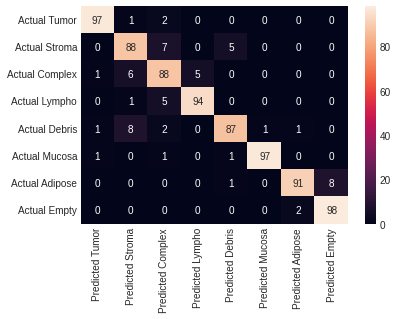

In [ ]:
classification_metrics = classification_report(test_df.label_num.values,predictions,target_names=list(label_num.keys()), output_dict=True)
print(classification_metrics)

cm = pd.DataFrame(data=confusion_matrix(test_df.label_num.values, predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7]),
                  index=["Actual Tumor", "Actual Stroma", "Actual Complex", "Actual Lympho", "Actual Debris", "Actual Mucosa", "Actual Adipose", "Actual Empty"],
                  columns=["Predicted Tumor", "Predicted Stroma", "Predicted Complex", "Predicted Lympho", "Predicted Debris", "Predicted Mucosa", "Predicted Adipose", "Predicted Empty"])
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
report = pd.DataFrame(classification_metrics)
report.to_csv('report-colorectal.csv', index=None)

report_history = history_train_acc, history_train_loss, history_val_acc, history_val_loss
report_history = pd.DataFrame(report_history)
report_history.to_csv('history-colorectal.csv', index=None)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('colorectal-checkpoint.pth')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

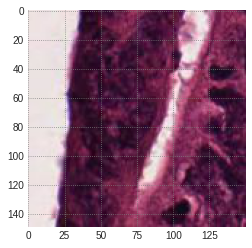

In [ ]:
image_path ='10264_CRC-Prim-HE-07_025.tif_Row_1801_Col_1.jpg'
pil_image = Image.open(image_path)
plt.imshow(pil_image)

In [ ]:
def process_image(pil_image):
    transforms = tt.Compose([
        tt.Resize((224, 224)),
        tt.ToTensor(),
        tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    pil_image = transforms(pil_image).float()
    
    np_image = np.array(pil_image)    
            
    return np_image

In [ ]:
def predict(pil_image, model):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Use GPU if it's available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(device)

    model.to(device)
    model.eval()
    
    np_image = process_image(pil_image)
    tensor_image = torch.from_numpy(np_image)
    
    inputs = Variable(tensor_image)
    
    if torch.cuda.is_available():
        inputs = Variable(tensor_image.float().cuda())           
        
    inputs = inputs.unsqueeze(dim = 0)
    logits = model.forward(inputs)
    probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
    labels = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']
    result = pd.DataFrame({'p': probabilities}, index=labels)
    return probabilities, labels, result

probabilities, labels, result = predict(pil_image, model)
print(probabilities)
print(labels)
print(result)

[9.9614823e-01 5.1780307e-07 3.0093463e-04 2.1957255e-04 3.7762456e-05
 3.2669900e-03 2.2777356e-05 3.2036369e-06]
['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adipose', 'Empty']
                    p
Tumor    9.961482e-01
Stroma   5.178031e-07
Complex  3.009346e-04
Lympho   2.195726e-04
Debris   3.776246e-05
Mucosa   3.266990e-03
Adipose  2.277736e-05
Empty    3.203637e-06


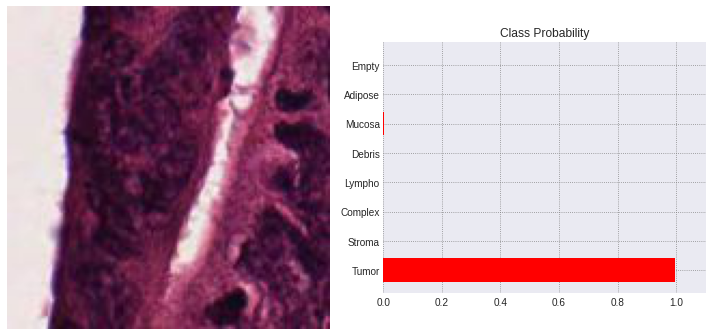

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(pil_image)
ax1.axis('off')
ax2.barh(np.arange(8), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(8))
ax2.set_yticklabels(labels)
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()